## Nonlinear MPC Double Lane Change Example

The bicycle model is the same one used in <a href=https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4>this paper (Figure 3)</a>

The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}

The 4 states are:
* $x$ and $y$, the car's position in the world frame
* $v$, the car's velocity
* $\psi$, the angle of the car's centerline in the world frame


The two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).

$\beta$ is the angle between the car's centerline and its velocity vector. It is not really a state, but a function of $\delta_f$.

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


## Set up road data
The road center (white dashed line) is smoothed (blue line) by this implementation.

In [1]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from trajectory_planner import TrajectoryPlanner
from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException

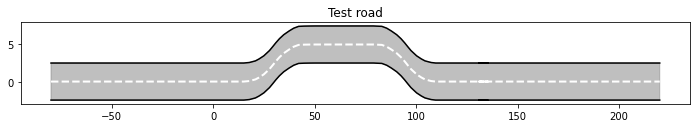

In [2]:
from road import iso_double_lane_change as test_road

left_width = 2.5*np.ones(np.size(test_road)//2)
right_width = 2.5*np.ones(np.size(test_road)//2)

# Plot the test road
def plot_road(ax, road, left_width, right_width):
    plt.title("Test road")
    ax.plot(road[:,0], road[:,1]+right_width, color="black")
    ax.plot(road[:,0], road[:,1]-left_width, color="black")
    ax.fill(np.concatenate([road[:,0], np.flip(road[:,0]), road[0:1,0]]),
             np.concatenate([road[:,1]+right_width, np.flip(road[:,1]-left_width), road[0:1,1]+right_width[0:1]]),
            color="grey", alpha=0.5)
    ax.plot(road[:,0], road[:,1], color="white", linestyle="--", linewidth=2)
    return ax

fig, ax = plt.subplots(1,1, figsize=(12,1.5))
plot_road(ax, test_road, left_width, right_width)
plt.show()

## Initialize the car and road model

In [3]:
# Initialize the car model with 0.075 second steps and 30 step lookahead
params = {"step":0.075,
          "N":30,
          "n":4, # 4 states
          "m":2, # 2 control inputs
         }
planner = TrajectoryPlanner(**params)

In [4]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        left_width  = left_width,
                        right_width  = right_width,
                        P           = np.size(left_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time

 [  0.]] is 10.0 away at s = 1.0, B(s) = [[290.]
 [  0.]]


### Set up the desired_speed function

In [5]:
DESIRED_SPEED = 10.0
def desired_speed(x, y, k):
    return DESIRED_SPEED


### Set up the driveable_corridor function

In [6]:
def driveable_corridor(x, y, s):
    state = roadrunner.save_state()
    step = roadrunner.advance_xy(np.array([x,y]))
    xy, angle, dl, dr = roadrunner.evaluate(s, full_data=True)
    xy = np.reshape(xy, 2)
    roadrunner.reset(**state)
    return xy[0], xy[1], angle, dl, dr

### Set up the constraint_generator
There's no constraint in this case, so we always return a value <= 0

In [7]:
def constraint_generator(z, k):
    def g(x, y, v, psi, index):
        return -1 # it has to be <= 0
    return g

### Initial conditions

In [8]:
xy, angle, dl, dr = roadrunner.evaluate(full_data=True)
ic = np.array([xy[0,0], xy[0,1], desired_speed(xy[0,0], xy[0,1], 0), angle])
print(ic)

[-80.   0.  10.   0.]


## Run the MPC algorithm

### Cost weights

In [9]:
weights = {
       "accuracy":10.0,
           "jerk":100.0,
"steering change":10.0,
   "acceleration":0.0,
}
# use acceleration weight for stopping scenario and decrease accuracy by 10x


# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 160

## Initialize the trajectory planner

In [10]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(40)

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], desired_speed(0, xy[0], xy[1]), roadrunner.get_angle()]
#planner.mpcprob.model.set_initial(ic, desired_speed, roadrunner)
z_est, u_est = planner.generate_first_estimate(ic, driveable_corridor, desired_speed, constraint_generator)
planner.mpcprob.model.state_estimate =z_est
planner.mpcprob.model.control_estimate =u_est

planner.setup_to_save_data(n_runs)

planner.z0 = ic
estimated_path, _, _ = planner.generate_path_estimate(driveable_corridor, desired_speed, constraint_generator)
planner.initialize_first_mpc_problem(estimated_path)


<IPython.core.display.Javascript object>


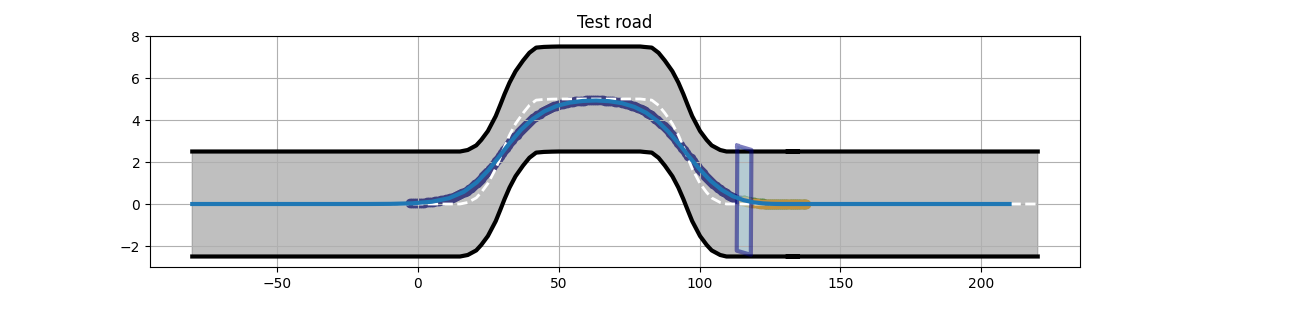

z0 [-2.85385740e+00  2.73199509e-02  1.00000000e+01  4.36620729e-03]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
               

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

z0 [12.87351903  0.34024262  9.96529657  0.03800978]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_

z0 [15.11160415  0.46753024  9.96133616  0.05126538]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

z0 [97.55127552  2.05045617  9.95144517 -0.16743623]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

NameError: name 'N' is not defined

In [11]:
%matplotlib notebook

# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+params["N"],4,2))

fig_traj = plt.figure(figsize=(12,3))
ax_traj = fig_traj.add_subplot(111)

plt.ion()
fig_traj.show()

states = ax_traj.plot(planner.x_true[0], planner.x_true[1], color="red")[0]
plt.xlim([0,100])

fig_traj.canvas.draw()

k = 0
try:
    while k < n_runs:
        print("z0", planner.z0)
        estimated_path, left_widths, right_widths = planner.generate_path_estimate(driveable_corridor, desired_speed, constraint_generator)
        # Solve the MPC problem
        problem = planner.build_mpc_problem(estimated_path, left_widths, right_widths, weights, constraint_generator(planner.z0, k))
        xk_opt, uk_opt, sol = planner.solve_mpc_problem(problem)

         # for plotting
        planner.centers[:,k+1] = planner.mpcprob.x_center_plot[:,1]

        # Save the next state x_k+1 and control u_k+1
        for i in range(params["n"]):
            planner.x_plan[i,k+1] = xk_opt[i][1]
        for i in range(params["m"]):
            planner.u_plan[i,k] = uk_opt[i][1]
        _,p = planner.mpcprob.bound_x(estimated_path[0,0], estimated_path[1,0], estimated_path[3,0], left_widths[0], right_widths[0])
        planner.polygon_boundaries[k,:,:] = p
        
        planner.x_true[:,k+1] = planner.apply_control(planner.u_plan[:,k])
        planner.z0 = planner.x_true[:,k+1]
        
        planner.initialize_nth_mpc_problem(xk_opt, uk_opt)
    
    
        # Advance the roadrunner to our new state at k+1
        step_xy = roadrunner.advance_xy(planner.x_true[0:2,k+1])

        print("Advanced by", step_xy,"to", roadrunner.evaluate())

        # for plotting
        # Plot arrows and x-y states
        ax_traj.clear()
        plot_road(ax_traj, test_road, left_width, right_width)
        ax_traj.scatter(planner.x_true[0,:k], planner.x_true[1,:k], color="navy")
        xy = np.reshape(roadrunner.evaluate(),(2,1))
        # Plot the polygon fill
        ax_traj.fill(planner.polygon_boundaries[k,:,0], planner.polygon_boundaries[k,:,1], "lightblue", alpha=0.5)
        # Plot the line around each polygon
        ax_traj.plot(np.concatenate([planner.polygon_boundaries[k,:,0],planner.polygon_boundaries[k,0:1,0]]),
                np.concatenate([planner.polygon_boundaries[k,:,1],planner.polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.5)
        
        ax_traj.scatter(estimated_path[0,:], estimated_path[1,:], color="green")
        
        ax_traj.scatter(xk_opt[0], xk_opt[1], color="orange")

        roadrunner.plot(ax=ax_traj, n_points=50)
        
        fig_traj.canvas.draw()
        # Done!
   

        if not sol['success']: # it failed
            print("FAILED: ipopt returned status", sol['success'], "\n", sol['return_status'])
            raise ValueError("ipopt failed and I need to make a better exception name")
        
        k += 1
        
except OutOfRoadPointsException as e:
    print(e)
finally:
    planner.x_plan = planner.x_plan[:,:k] # Cut the vectors shorter so they don't have unitialized values
    planner.u_plan = planner.u_plan[:,:k-1]  
    planner.x_true = planner.x_true[:,k]
    planner.centers = planner.centers[:,k]
    # store the polygon boundary for each step, so we can plot them later
    polygon_boundaries = polygon_boundaries[:k+N,:,:]
    fig_traj.canvas.draw()


In [12]:
# turn interactive plotting off
plt.ioff()

## Control signals: acceleration and steering angle

<IPython.core.display.Javascript object>


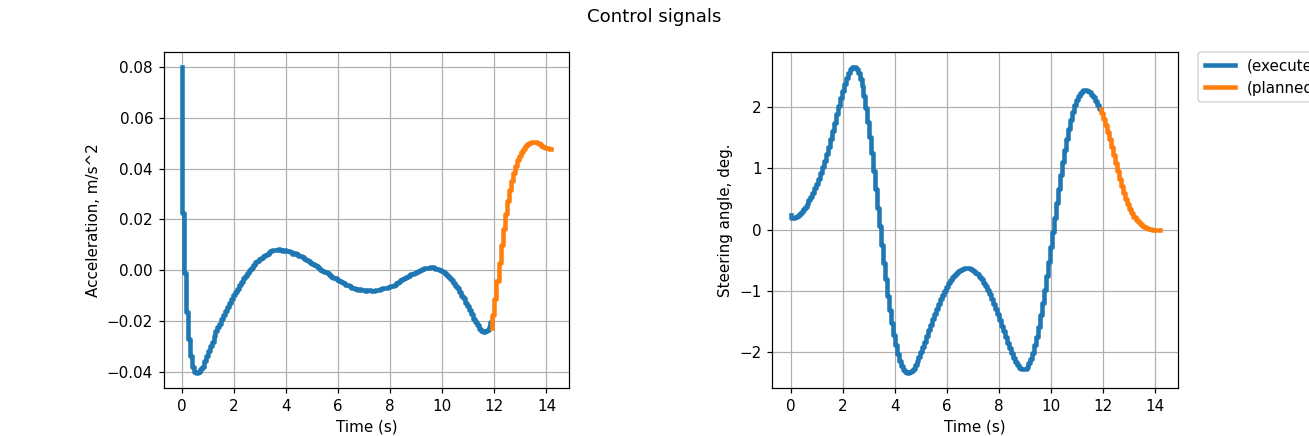

In [13]:
from KinematicBicycleCar import plot_u
u_plt, u_ax1, u_ax2 = plot_u(planner.u_plan, planner.mpcprob.u_opt, params["step"], params["N"])

plt.show()

## x-y plot of car's path
Arrows show velocity. Orange components are planned but not executed.

<IPython.core.display.Javascript object>


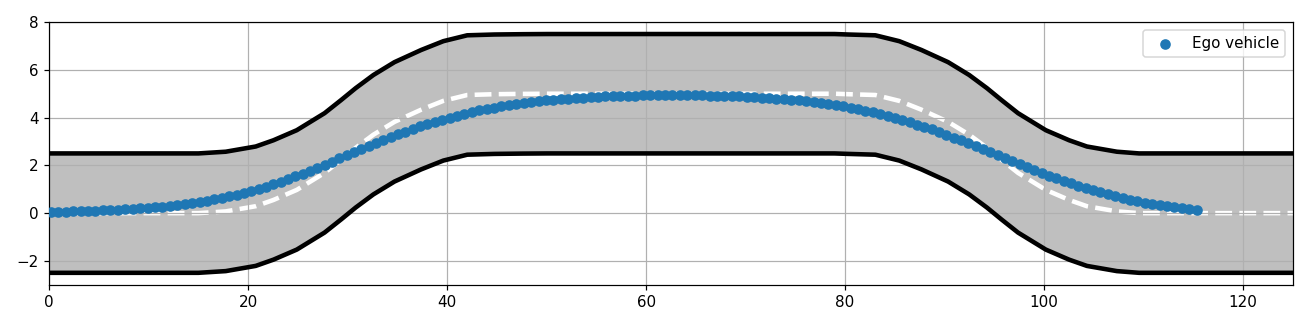

In [18]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
plt.xlim(0, 125)
ax.plot(test_road[:,0], test_road[:,1]+right_width, color="black")
ax.plot(test_road[:,0], test_road[:,1]-left_width, color="black")
ax.fill(np.concatenate([test_road[:,0], np.flip(test_road[:,0]), test_road[0:1,0]]),
         np.concatenate([test_road[:,1]+right_width, np.flip(test_road[:,1]-left_width), test_road[0:1,1]+right_width[0:1]]),
        color="grey", alpha=0.5, zorder=0)
ax.plot(test_road[:,0], test_road[:,1], linestyle="--", color="white", zorder=1)

ax.scatter(planner.x_plan[0,:], planner.x_plan[1,:], zorder=4, label="Ego vehicle")
    
plt.show()
plt.legend()
plt.tight_layout()
plt.savefig("double_lane_change.pdf")

<IPython.core.display.Javascript object>


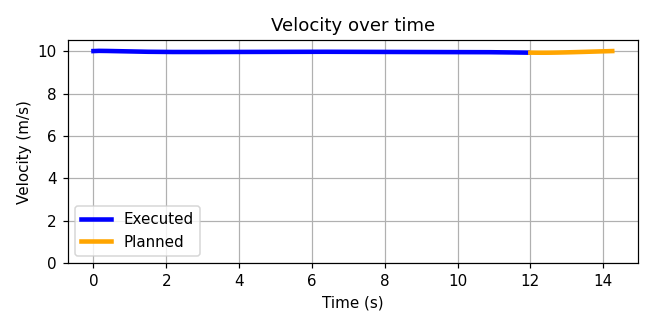

In [20]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.plot(np.arange(np.size(planner.x_plan[2,:k]))*planner.step, planner.x_plan[2,:k], color="blue", label="Executed")
ax.plot(np.arange(np.size(planner.mpcprob.x_opt[2,:]))*planner.step + np.size(planner.x_plan[2,:])*planner.step, planner.mpcprob.x_opt[2,:], color="orange", label="Planned")
plt.ylim(0, 10.5)
plt.legend()
plt.ylabel("Velocity (m/s)"); plt.xlabel("Time (s)")
plt.title("Velocity over time")
plt.show()
plt.tight_layout()
plt.savefig("double_lane_change_velocity.pdf")